In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=3df711ac287eb72d050660cc6ed156b2419e9f6463dc1f824742a612d8291f7d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [4]:
data = pd.read_csv('/kaggle/input/eurusd/EURUSD-30-DS.csv', header=None, names=['Date','Open', 'High', 'Low', 'Close','Volume'])
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45770,1.45937,6473.2500
1,01.01.2008 02:30:00.000,1.45965,1.45982,1.45768,1.45785,6484.6000
2,01.01.2008 03:00:00.000,1.45788,1.45803,1.45761,1.45784,4957.6000
3,01.01.2008 03:30:00.000,1.45788,1.45794,1.45754,1.45770,3416.5500
4,01.01.2008 04:00:00.000,1.45770,1.45983,1.45766,1.45954,5553.4375


In [9]:
import pandas_ta as ta
data['RSI'] = ta.rsi(data['Close'], length=14)
data['MA20'] = ta.sma(data['Close'], length=20)
data['MACD'] = ta.macd(data['Close'])['MACD_12_26_9']
data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
data = data.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [10]:
data.head()

,Date,Open,High,Low,Close,Volume,RSI,MA20,MACD,ATR
50,02.01.2008 03:00:00.000,1.46006,1.46037,1.45938,1.45952,5096.0470,50.252183,1.459476,0.000572,0.001620
51,02.01.2008 03:30:00.000,1.45981,1.46059,1.45950,1.46030,3550.0940,54.947605,1.459542,0.000564,0.001576
52,02.01.2008 04:00:00.000,1.46020,1.46189,1.45987,1.46170,5232.4000,61.898772,1.459690,0.000663,0.001612
53,02.01.2008 04:30:00.000,1.46164,1.46203,1.46074,1.46190,6133.2000,62.782212,1.459840,0.000749,0.001586
54,02.01.2008 05:00:00.000,1.46179,1.46253,1.46099,1.46129,7933.8375,58.339147,1.459963,0.000760,0.001582


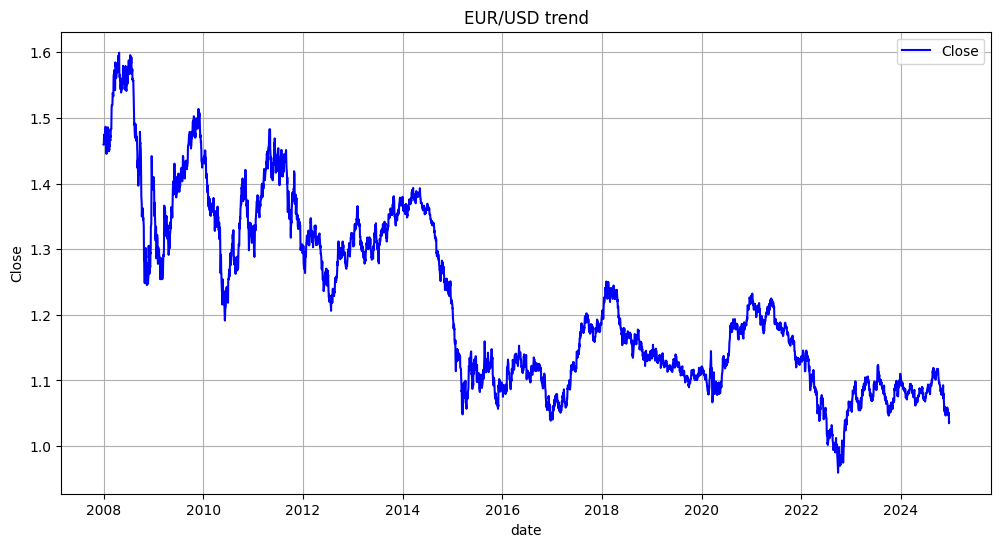

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')
df['Day'] = df['Date'].dt.date
daily_data = df.groupby('Day').first().reset_index()  # اولین نمونه هر روز

# 4. رسم Line Plot برای Close
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Close'], label='Close', color='blue')

# 5. تنظیمات نمودار
plt.title('EUR/USD trend')
plt.xlabel('date')
plt.ylabel('Close')
plt.legend()
plt.grid(True)

# 6. نمایش
plt.show()

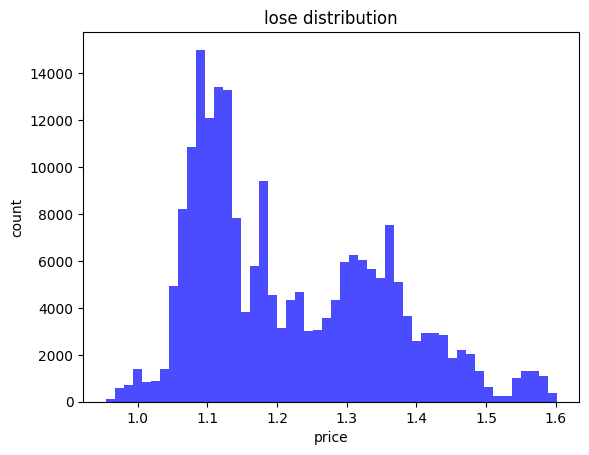

In [5]:
plt.hist(df['Close'], bins=50, color='blue', alpha=0.7)
plt.title('lose distribution')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

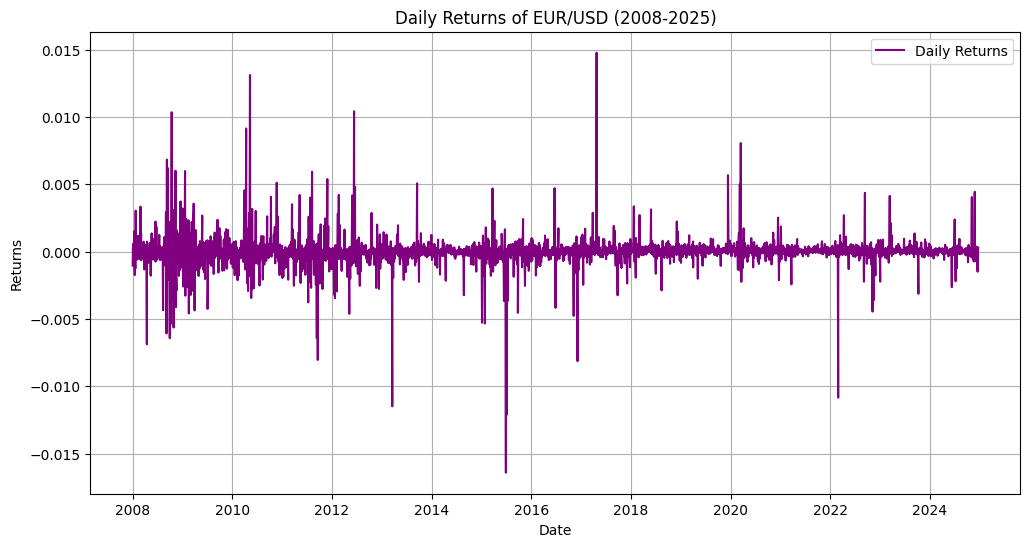

In [6]:
# Ensure 'Returns' is calculated only if not already present
if 'Returns' not in df.columns:
    df['Returns'] = df['Close'].pct_change()

if 'Returns' not in daily_data.columns:
    daily_data['Returns'] = daily_data['Close'].pct_change()

# Plotting daily returns
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Day'], daily_data['Returns'], label='Daily Returns', color='purple')
plt.title('Daily Returns of EUR/USD (2008-2025)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

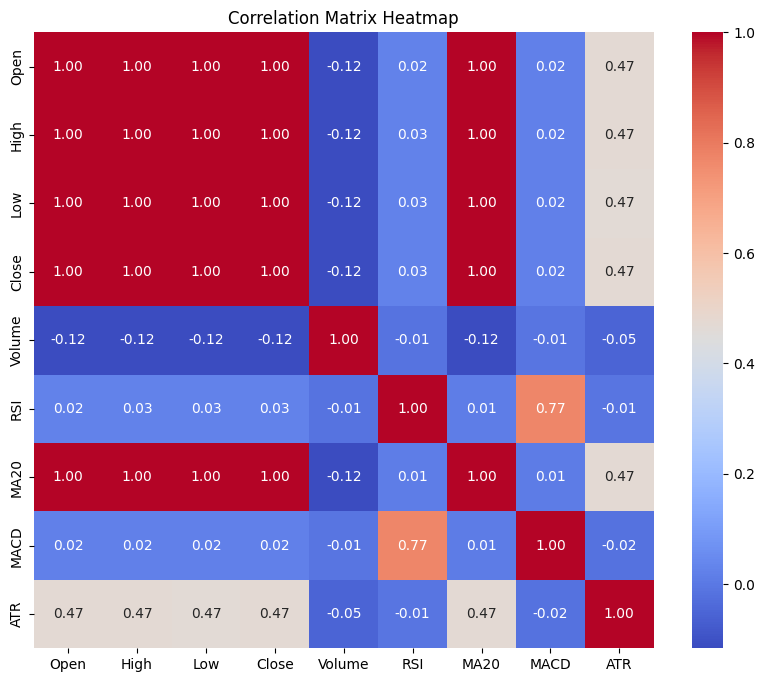

In [12]:
import seaborn as sns
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume','RSI','MA20','MACD','ATR']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [13]:
input_features = ['Close', 'Volume', 'RSI', 'MA20', 'MACD', 'ATR']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Open', 'High', 'Low', 'Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [14]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [15]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 169448
تعداد نمونه‌های Validation: 21181
تعداد نمونه‌های Test: 21182


In [16]:
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(60, len(input_features))))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(4))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=128, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 0.0156 - mae: 0.0779 - val_loss: 5.6708e-05 - val_mae: 0.0063
Epoch 2/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 3.0506e-05 - val_mae: 0.0042
Epoch 3/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 9.2597e-04 - mae: 0.0215 - val_loss: 6.6984e-04 - val_mae: 0.0238
Epoch 4/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 8.5605e-04 - mae: 0.0207 - val_loss: 2.8310e-05 - val_mae: 0.0042
Epoch 5/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 8.2130e-04 - mae: 0.0204 - val_loss: 2.6576e-05 - val_mae: 0.0041
Epoch 6/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 8.1430e-04 - mae: 0.0203 - val_loss: 4.2730e-04 - val_mae: 0.0195
Epoch 7/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 8.0431e-04 - mae: 0.0200 - val_loss: 4.1001e-04 - val_mae: 0.0198
Epoch 8/50
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 7.9306e-04 - mae: 0.0200 - val_los

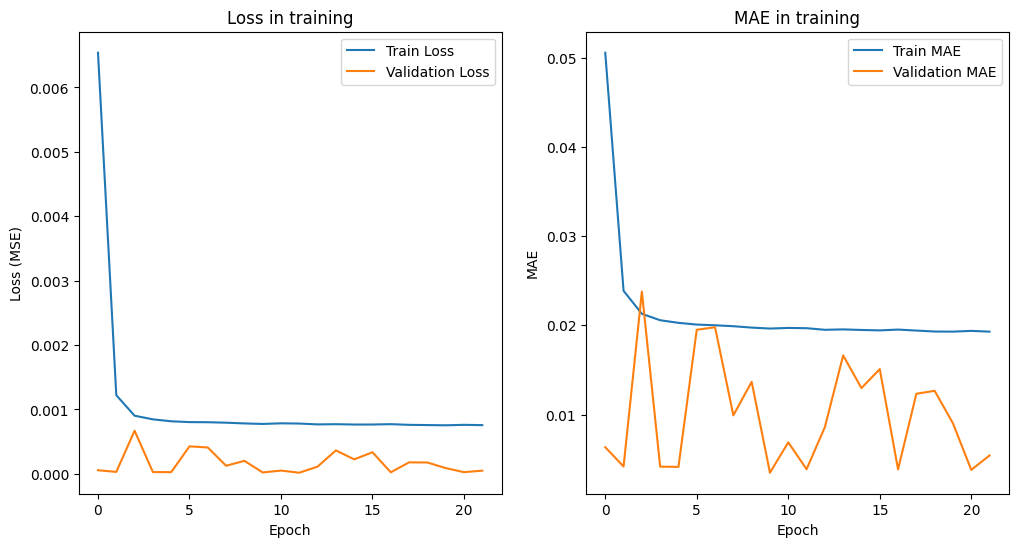

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

معیارهای ارزیابی برای Open:
MSE: 2.474091721429915e-05
RMSE: 0.004974024247457902
MAE: 0.0038877813614323097
R² Score: 0.912358749382775

معیارهای ارزیابی برای High:
MSE: 2.4493800833105e-05
RMSE: 0.004949121218267441
MAE: 0.0038081286420093676
R² Score: 0.9130504052465916

معیارهای ارزیابی برای Low:
MSE: 2.5407134784066164e-05
RMSE: 0.005040549055813877
MAE: 0.003947705810090524
R² Score: 0.910140564656318

معیارهای ارزیابی برای Close:
MSE: 2.5052074201909645e-05
RMSE: 0.005005204711289004
MAE: 0.003862965965017067
R² Score: 0.9112800264907835

دقت جهت برای Close: 48.21302110381946%


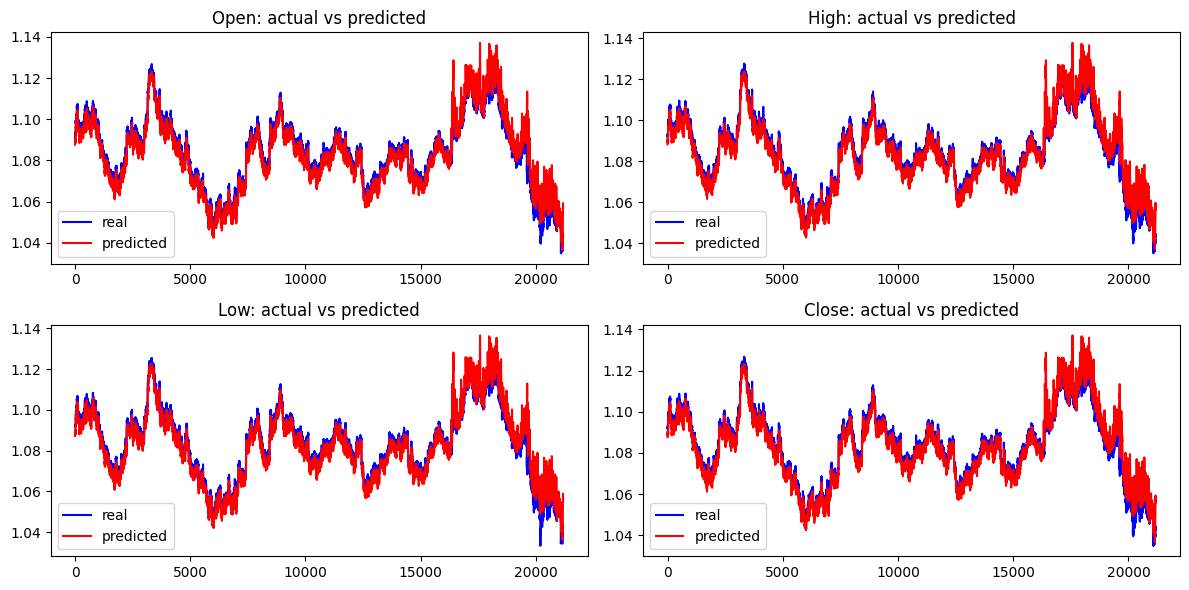

In [19]:
# 9. پیش‌بینی
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_open = scalers_outputs['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1))
predictions_high = scalers_outputs['High'].inverse_transform(predictions[:, 1].reshape(-1, 1))
predictions_low = scalers_outputs['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1))
predictions_close = scalers_outputs['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1))

y_test_open = scalers_outputs['Open'].inverse_transform(y_test[:, 0].reshape(-1, 1))
y_test_high = scalers_outputs['High'].inverse_transform(y_test[:, 1].reshape(-1, 1))
y_test_low = scalers_outputs['Low'].inverse_transform(y_test[:, 2].reshape(-1, 1))
y_test_close = scalers_outputs['Close'].inverse_transform(y_test[:, 3].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_open, predictions_open, "Open")
calculate_metrics(y_test_high, predictions_high, "High")
calculate_metrics(y_test_low, predictions_low, "Low")
calculate_metrics(y_test_close, predictions_close, "Close")

# 12. دقت جهت برای Close
correct_directions = np.sum(np.sign(predictions_close[1:] - predictions_close[:-1]) == np.sign(y_test_close[1:] - y_test_close[:-1]))
directional_accuracy = correct_directions / (len(predictions_close) - 1)
print(f"\nدقت جهت برای Close: {directional_accuracy * 100}%")

# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(y_test_open, label='real', color='blue')
plt.plot(predictions_open, label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high, label='real', color='blue')
plt.plot(predictions_high, label='predicted', color='red')
plt.title('High: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low, label='real', color='blue')
plt.plot(predictions_low, label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close, label='real', color='blue')
plt.plot(predictions_close, label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.legend()

plt.tight_layout()
plt.show()

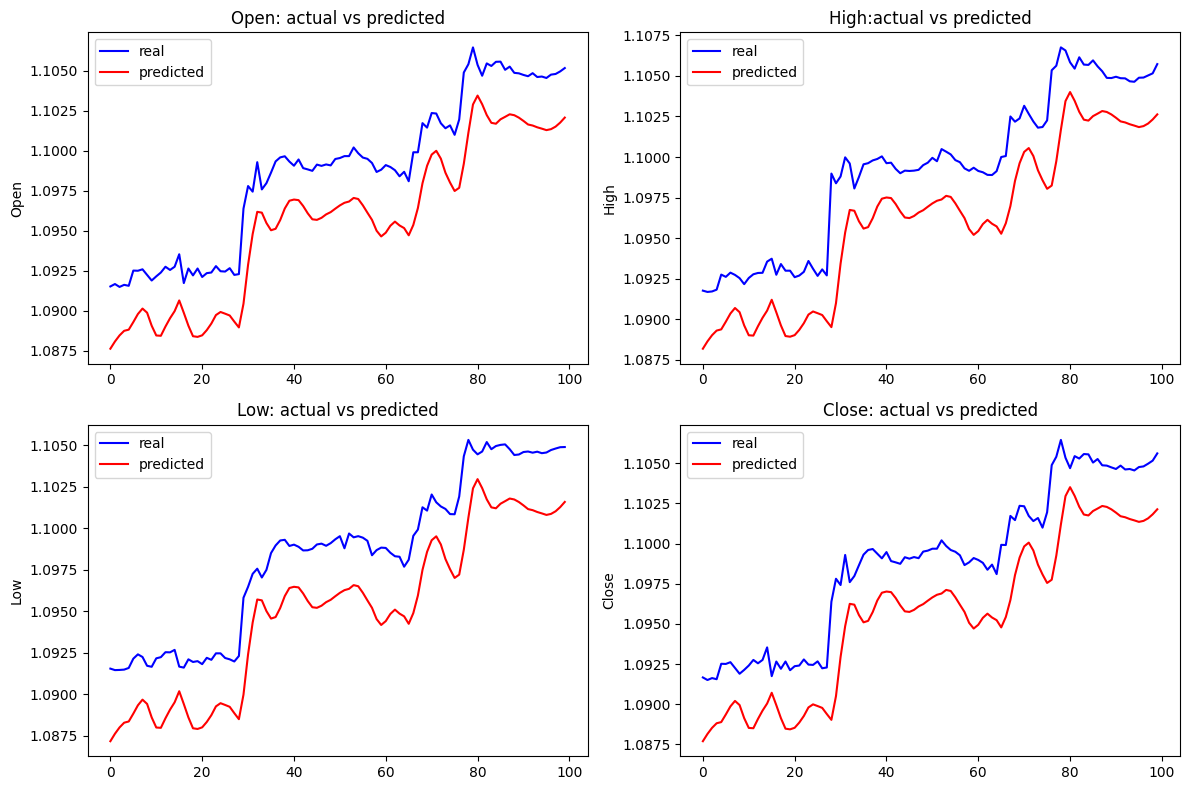

In [20]:
n_samples = 100  # تعداد نمونه‌هایی که می‌خوای نشون بدی

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(y_test_open[:n_samples], label='real', color='blue')
plt.plot(predictions_open[:n_samples], label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.ylabel('Open')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high[:n_samples], label='real', color='blue')
plt.plot(predictions_high[:n_samples], label='predicted', color='red')
plt.title('High:actual vs predicted')
plt.ylabel('High')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low[:n_samples], label='real', color='blue')
plt.plot(predictions_low[:n_samples], label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.ylabel('Low')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close[:n_samples], label='real', color='blue')
plt.plot(predictions_close[:n_samples], label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.ylabel('Close')
plt.legend()

plt.tight_layout()
plt.show()